## Education Network analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
import networkx as nx

# load CSV file
df = pd.read_csv("mayors_edu_long.csv")

# take a look
df.head()

,personLabel,birthDate,genderLabel,partyLabel,start,end,positionLabel,cityLabel,eduLabel,eduTypeLabel
0,A. A. Ames,1842-01-18T00:00:00Z,male,Republican Party of Minnesota,1876-04-11T00:00:00Z,1877-04-10T00:00:00Z,Mayor of Minneapolis,Minneapolis,Rush Medical College,medical school
1,A. A. Ames,1842-01-18T00:00:00Z,male,Republican Party of Minnesota,1882-04-11T00:00:00Z,1884-04-08T00:00:00Z,Mayor of Minneapolis,Minneapolis,Rush Medical College,medical school
2,A. A. Ames,1842-01-18T00:00:00Z,male,Republican Party of Minnesota,1886-04-13T00:00:00Z,1889-01-07T00:00:00Z,Mayor of Minneapolis,Minneapolis,Rush Medical College,medical school
3,A. A. Ames,1842-01-18T00:00:00Z,male,Republican Party of Minnesota,1901-01-07T00:00:00Z,1902-08-27T00:00:00Z,Mayor of Minneapolis,Minneapolis,Rush Medical College,medical school
4,Abraham Beame,1906-03-20T00:00:00Z,male,Democratic Party,1974-01-01T00:00:00Z,1977-12-31T00:00:00Z,Mayor of New York City,New York City,Baruch College,university


In [2]:
# Total number of distinct values
print("Distinct mayors:", df['personLabel'].nunique())
print("Distinct political parties:", df['partyLabel'].nunique())
print("Distinct universities (eduLabel):", df['eduLabel'].nunique())
print("Distinct education types (eduTypeLabel):", df['eduTypeLabel'].nunique())

Distinct mayors: 562
Distinct political parties: 25
Distinct universities (eduLabel): 719
Distinct education types (eduTypeLabel): 118


In [3]:
print("\nTop parties:")
print(df['partyLabel'].value_counts().head())

print("\nTop universities (eduLabel):")
print(df['eduLabel'].value_counts().head())

print("\nTop education types (eduTypeLabel):")
print(df['eduTypeLabel'].value_counts().head())

print("\nTop mayors:")
print(df['personLabel'].value_counts().head())


Top parties:
partyLabel
Democratic Party                           2113
Republican Party                            807
independent politician                       45
Minnesota Democratic–Farmer–Labor Party      28
California Democratic Party                  15
Name: count, dtype: int64

Top universities (eduLabel):
eduLabel
Yale University             96
Columbia University         65
University of Tennessee     63
University of Notre Dame    60
Harvard Law School          42
Name: count, dtype: int64

Top education types (eduTypeLabel):
eduTypeLabel
private not-for-profit educational institution         386
public educational institution of the United States    320
university                                             233
high school                                            219
law school                                             176
Name: count, dtype: int64

Top mayors:
personLabel
Kyle Testerman       32
Charlie Luken        28
Michael Bloomberg    24
London Breed         

In [4]:
def build_university_counts(csv_path, min_count=1):
    df = pd.read_csv(csv_path)

    # drop rows with missing university or start date
    df = df.dropna(subset=['eduLabel', 'start'])

    # count distinct start dates per person
    terms_per_person = (df.groupby('personLabel')['start']
                          .nunique()
                          .reset_index(name='terms'))

    # unique (person, university) pairs
    person_unis = df[['personLabel', 'eduLabel']].drop_duplicates()

    # merge terms with each (person, university) pair
    merged = person_unis.merge(terms_per_person, on='personLabel', how='left')

    # aggregate per university
    out = (merged.groupby('eduLabel')
                 .agg(counts=('terms', 'sum'),
                      distinct_mayors=('personLabel', 'nunique'))
                 .reset_index()
                 .rename(columns={'eduLabel': 'University'}))

    # filter out low-count universities
    if min_count is not None and min_count > 1:
        out = out[out['counts'] >= min_count]

    # sort for readability
    out = out.sort_values(['counts', 'distinct_mayors', 'University'],
                          ascending=[False, False, True]).reset_index(drop=True)
    return out


table = build_university_counts("mayors_edu_long.csv", min_count=1)  # keep all
# table = build_university_counts("/mnt/data/mayors_edu_long.csv", min_count=2)  # exclude single-count
print(table.head(10))

table.info()


                                    University  counts  distinct_mayors
0                              Yale University      16               16
1                           Harvard Law School      14               14
2                          Columbia University      12               10
3         John F. Kennedy School of Government      10               10
4           University of California, Berkeley       9                9
5  University of North Carolina at Chapel Hill       9                9
6                 George Washington University       8                8
7                        Ohio State University       8                8
8            University of Michigan Law School       8                8
9                               primary school       8                8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Universit

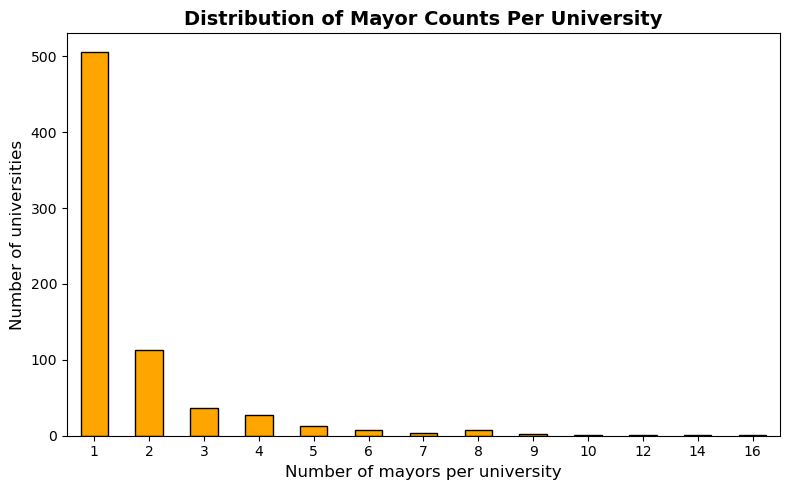

counts
1     505
2     113
3      37
4      27
5      13
6       7
7       4
8       7
9       2
10      1
12      1
14      1
16      1
Name: count, dtype: int64

In [5]:
# build your university table first
table = build_university_counts("mayors_edu_long.csv", min_count=1)

# contingency table: how many universities per mayor-count
contingency = table['counts'].value_counts().sort_index()

# plot
plt.figure(figsize=(8,5))
contingency.plot(kind='bar', color='orange', edgecolor='black')

plt.title("Distribution of Mayor Counts Per University", fontsize=14, weight='bold')
plt.xlabel("Number of mayors per university", fontsize=12)
plt.ylabel("Number of universities", fontsize=12)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


# contingency table: frequency of universities per mayor-count
contingency = table['counts'].value_counts().sort_index()
contingency.columns = ['mayor_counts', 'num_universities']
contingency

In [6]:
def build_university_network_table(csv_path, min_count=1):
    # ---- Load & prep
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=["personLabel", "eduLabel"])  # minimal cleanliness

    # If 'start' exists, use it to count distinct terms; otherwise fall back to 1 per person
    if "start" in df.columns:
        # Keep rows with start for the term counting step; keep missing starts for the (person, edu) mapping
        df_terms = df.dropna(subset=["start"]).copy()
        terms_per_person = (df_terms.groupby("personLabel")["start"]
                                    .nunique()
                                    .rename("terms")
                                    .reset_index())
    else:
        # Fallback: each person contributes 1 term
        terms_per_person = (df.groupby("personLabel")
                              .size()
                              .rename("terms")
                              .reset_index())
        terms_per_person["terms"] = 1

    # Unique (person, university) pairs (each mayor listed once per university)
    person_unis = df[["personLabel", "eduLabel"]].drop_duplicates()

    # Attach term counts to each (person, university) pair
    merged = person_unis.merge(terms_per_person, on="personLabel", how="left").fillna({"terms": 0})

    # --- Per-university summary
    uni_counts = (merged.groupby("eduLabel")
                         .agg(mayor_counts=("terms", "sum"),
                              distinct_mayors=("personLabel", "nunique"))
                         .reset_index()
                         .rename(columns={"eduLabel": "university"}))

    # Optional filter: exclude tiny universities by total count
    if min_count and min_count > 1:
        uni_counts = uni_counts[uni_counts["mayor_counts"] >= min_count].copy()

    # --- Build university–university edges by shared *unique mayors*
    # For each person, find the unique universities they attended (within the kept set)
    kept_unis = set(uni_counts["university"])
    person_unis_kept = (person_unis[person_unis["eduLabel"].isin(kept_unis)]
                        .groupby("personLabel")["eduLabel"]
                        .apply(lambda s: sorted(set(s)))
                        .reset_index(name="unis"))

    # Count co-attendance (each person contributes 1 to each pair they link)
    edge_weights = {}
    for unis in person_unis_kept["unis"]:
        if len(unis) < 2:
            continue
        for u, v in itertools.combinations(unis, 2):
            key = tuple(sorted((u, v)))
            edge_weights[key] = edge_weights.get(key, 0) + 1

    # --- Construct graph
    G = nx.Graph()
    # Add all kept universities as nodes (even isolates)
    for u in kept_unis:
        G.add_node(u)

    # Add weighted edges
    for (u, v), w in edge_weights.items():
        G.add_edge(u, v, weight=float(w))

    # --- Centralities
    # Unweighted & weighted degrees
    deg_unw = dict(G.degree())
    deg_w   = dict(G.degree(weight="weight"))

    # Betweenness (use weights; normalized)
    bet = nx.betweenness_centrality(G, weight="weight", normalized=True)

    # Eigenvector centrality (weighted). Use power iteration; fall back to zeros if it fails to converge.
    try:
        eig = nx.eigenvector_centrality(G, weight="weight", max_iter=1000, tol=1e-06)
    except nx.NetworkXError:
        eig = {n: 0.0 for n in G.nodes()}
    except nx.PowerIterationFailedConvergence:
        eig = {n: 0.0 for n in G.nodes()}

    # --- Assemble final table
    cent_df = pd.DataFrame({
        "university": list(G.nodes()),
        "degree_unweighted": [deg_unw.get(n, 0) for n in G.nodes()],
        "degree_weighted":   [deg_w.get(n, 0.0) for n in G.nodes()],
        "betweenness":       [bet.get(n, 0.0) for n in G.nodes()],
        "eigenvector":       [eig.get(n, 0.0) for n in G.nodes()],
    })

    out = (uni_counts.merge(cent_df, on="university", how="left")
                    .sort_values(["mayor_counts", "degree_unweighted", "university"],
                                 ascending=[False, False, True])
                    .reset_index(drop=True))

    # Nice types
    out["degree_unweighted"] = out["degree_unweighted"].astype(int)
    return out

# --------- Example usage ---------
table = build_university_network_table("mayors_edu_long.csv", min_count=1)
table.head(15)

,university,mayor_counts,distinct_mayors,degree_unweighted,degree_weighted,betweenness,eigenvector
0,Yale University,16,16,25,26.0,0.071016,2.056970e-01
1,Harvard Law School,14,14,26,28.0,0.055478,4.166984e-01
2,Columbia University,12,10,20,21.0,0.058483,3.067858e-01
3,John F. Kennedy School of Government,10,10,21,22.0,0.061410,3.480651e-01
4,"University of California, Berkeley",9,9,19,19.0,0.033764,1.192948e-01
5,University of North Carolina at Chapel Hill,9,9,9,9.0,0.027035,8.963966e-02
6,primary school,8,8,19,20.0,0.031395,7.212902e-02
7,Ohio State University,8,8,11,12.0,0.015762,1.459361e-02
8,University of Maryland Francis King Carey Scho...,8,6,9,10.0,0.006883,3.854487e-02
9,University of Michigan Law School,8,8,9,12.0,0.013269,7.109316e-02


In [7]:
CSV = "mayors_edu_long.csv"

# ---------- Build table + graph (same logic as before, compact) ----------
def build_table_and_graph(csv_path, min_count=1):
    df = pd.read_csv(csv_path).dropna(subset=["personLabel", "eduLabel"])

    # distinct terms per person = distinct start dates (fallback to 1 if no 'start')
    if "start" in df.columns:
        terms_per_person = (df.dropna(subset=["start"])
                              .groupby("personLabel")["start"].nunique()
                              .reset_index(name="terms"))
    else:
        terms_per_person = df.groupby("personLabel").size().reset_index(name="terms")
        terms_per_person["terms"] = 1

    person_unis = df[["personLabel", "eduLabel"]].drop_duplicates()
    merged = person_unis.merge(terms_per_person, on="personLabel", how="left")

    # per-university counts
    uni = (merged.groupby("eduLabel")
                 .agg(mayor_counts=("terms", "sum"),
                      distinct_mayors=("personLabel", "nunique"))
                 .reset_index()
                 .rename(columns={"eduLabel": "university"}))
    if min_count and min_count > 1:
        uni = uni[uni["mayor_counts"] >= min_count].copy()

    kept = set(uni["university"])
    per_person_unis = (person_unis[person_unis["eduLabel"].isin(kept)]
                       .groupby("personLabel")["eduLabel"]
                       .apply(lambda s: sorted(set(s))))

    # edges weighted by shared unique mayors
    w = {}
    for unis in per_person_unis:
        for u, v in itertools.combinations(unis, 2):
            key = tuple(sorted((u, v)))
            w[key] = w.get(key, 0) + 1

    G = nx.Graph()
    G.add_nodes_from(kept)
    for (u, v), weight in w.items():
        G.add_edge(u, v, weight=float(weight))

    # centralities
    deg_unw = dict(G.degree())
    deg_w   = dict(G.degree(weight="weight"))
    bet     = nx.betweenness_centrality(G, weight="weight", normalized=True)
    try:
        eig = nx.eigenvector_centrality(G, weight="weight", max_iter=1000)
    except Exception:
        eig = {n: 0.0 for n in G.nodes()}

    tbl = (uni.merge(pd.DataFrame({
                "university": list(G.nodes()),
                "degree_unweighted": [deg_unw.get(n, 0) for n in G.nodes()],
                "degree_weighted":   [deg_w.get(n, 0.0) for n in G.nodes()],
                "betweenness":       [bet.get(n, 0.0) for n in G.nodes()],
                "eigenvector":       [eig.get(n, 0.0) for n in G.nodes()],
           }), on="university", how="left")
           .sort_values(["mayor_counts","degree_unweighted"], ascending=False)
           .reset_index(drop=True))
    return tbl, G

table, G = build_table_and_graph(CSV, min_count=1)




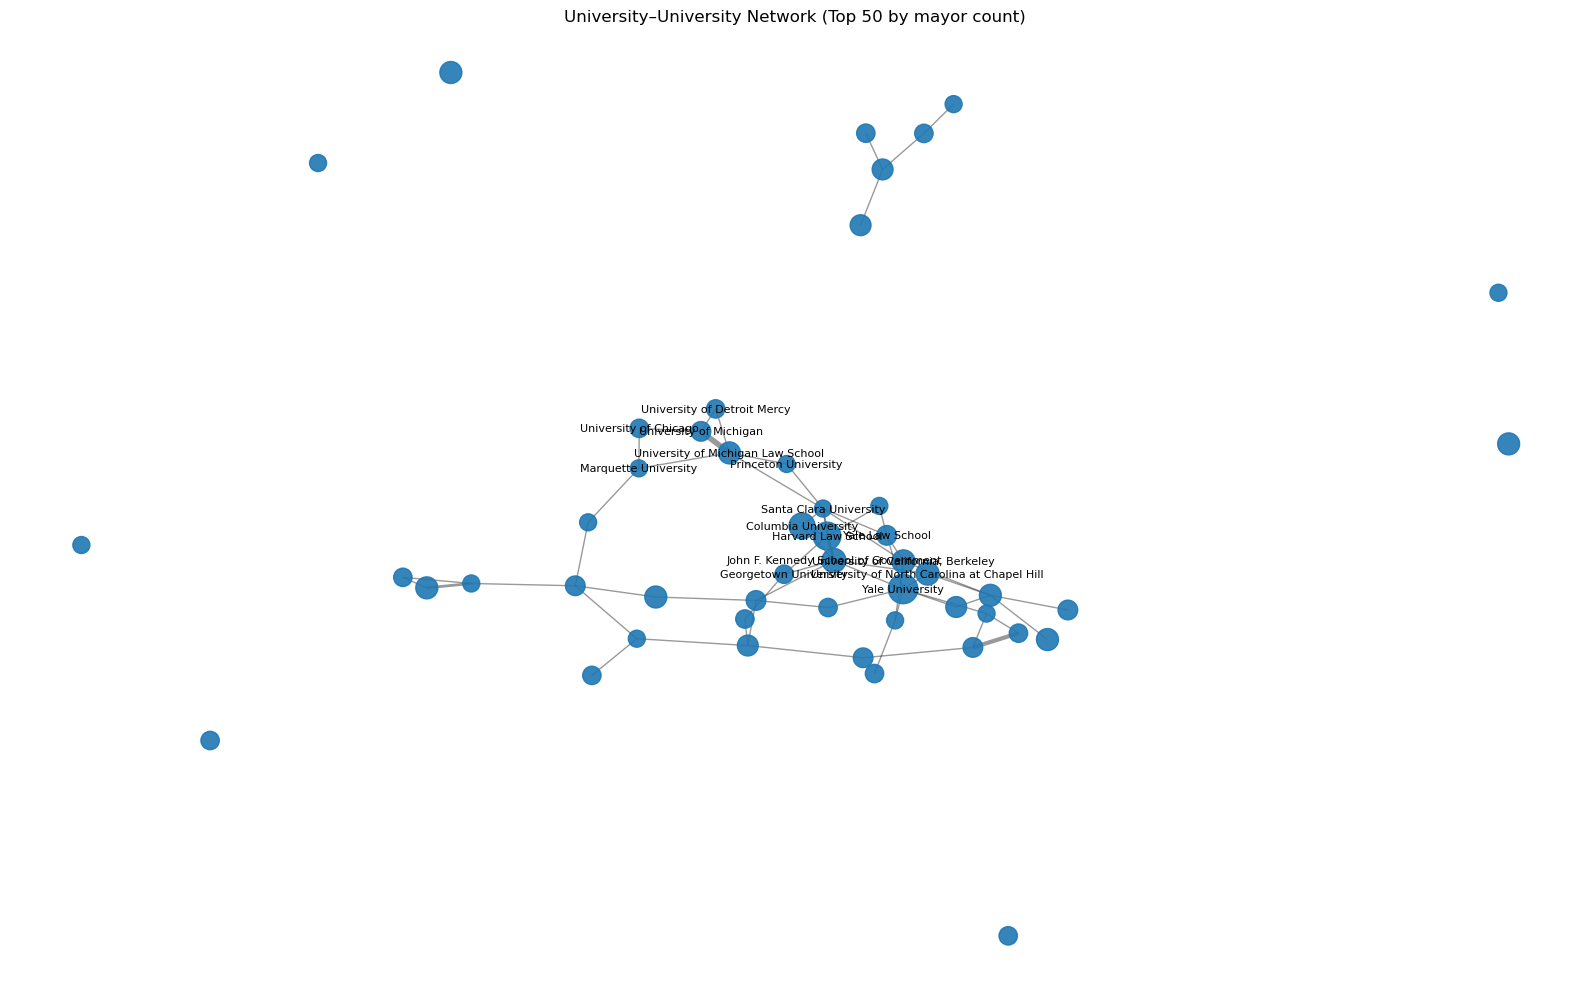

In [8]:
# ---------- 1) University–University network plot ----------
# parameters you can tweak:
TOP_N = 50       # show top N universities by mayor_counts
LABEL_K = 15     # label top K by eigenvector within the shown subgraph

top_nodes = table.head(TOP_N)["university"].tolist()
H = G.subgraph(top_nodes).copy()

pos = nx.spring_layout(H, seed=42)

# node sizes proportional to mayor_counts
counts_map = dict(zip(table["university"], table["mayor_counts"]))
node_sizes = [50 + 25*counts_map.get(n, 1) for n in H.nodes()]  # simple scaling

# edge widths from weights
edge_widths = [H[u][v].get("weight", 1) for u, v in H.edges()]

plt.figure(figsize=(16, 10))
nx.draw_networkx_edges(H, pos, width=edge_widths, alpha=0.4)
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, alpha=0.9)

# labels for top-K by eigenvector (computed on H)
eig_H = nx.eigenvector_centrality(H, weight="weight", max_iter=1000)
label_nodes = {n for n,_ in sorted(eig_H.items(), key=lambda x: x[1], reverse=True)[:LABEL_K]}
labels = {n: n if n in label_nodes else "" for n in H.nodes()}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)

plt.title("University–University Network (Top {} by mayor count)".format(TOP_N))
plt.axis("off")
plt.tight_layout()
plt.savefig("edu_edu_network.png", dpi=300, bbox_inches="tight")
plt.show()

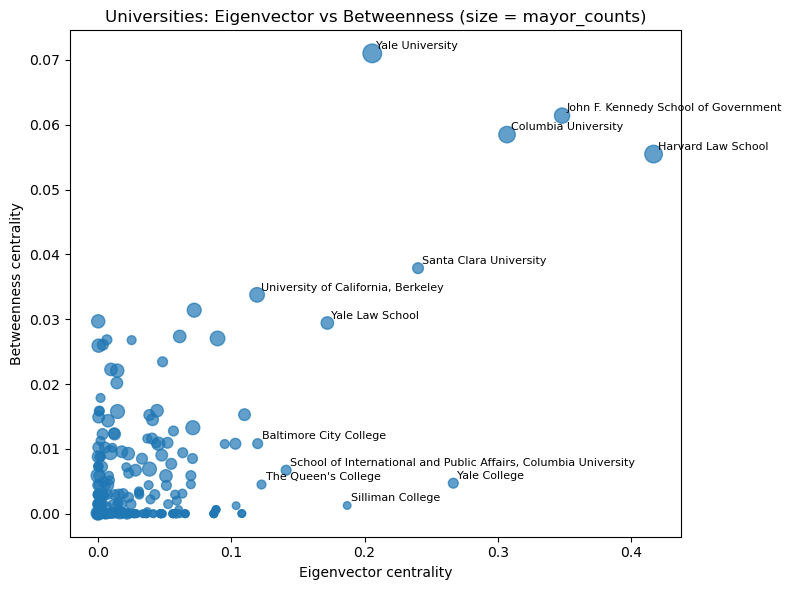

In [9]:
# ---------- 2) Eigenvector vs Betweenness scatter (point size = mayor_counts) ----------
x = table["eigenvector"].values
y = table["betweenness"].values
sizes = 20 + 10*table["mayor_counts"].values  # simple size mapping

plt.figure(figsize=(8,6))
plt.scatter(x, y, s=sizes, alpha=0.7)

plt.xlabel("Eigenvector centrality")
plt.ylabel("Betweenness centrality")
plt.title("Universities: Eigenvector vs Betweenness (size = mayor_counts)")

# (optional) annotate a few notable points by eigenvector
for uni, xv, yv in table.nlargest(12, "eigenvector")[["university","eigenvector","betweenness"]].itertuples(index=False):
    plt.annotate(uni, (xv, yv), xytext=(3,3), textcoords="offset points", fontsize=8)

plt.tight_layout()
plt.savefig("betweenness.png", dpi=300, bbox_inches="tight")
plt.show()

### Network Analysis of Universities
Several graphs show network centrality measures:
- Degree centrality = how many connections a university has with others (shared mayors).
- Betweenness centrality = how often a university serves as a “bridge” between otherwise unconnected universities.
- Eigenvector centrality = influence in the network, favoring universities connected to other influential schools.

### Key Results:
- Harvard Law School has very high eigenvector centrality → influential, strongly connected with other elite schools.
- Yale University has the highest raw number of mayors, but slightly less central than Harvard in the network.
- Columbia University and John F. Kennedy School of Government act as bridges (high betweenness).
- Some smaller schools (like primary schools) surprisingly show connections, but mostly because a few mayors share that background.

### The 8 Ivy League schools are:
- Harvard University
- Yale University
- Princeton University
- Columbia University
- Brown University
- Dartmouth College
- University of Pennsylvania
- Cornell University